In [8]:
import os 
import netCDF4 as nc 
import xarray as xa
import numpy as np
import time
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import analysis
import scipy.signal
from sklearn.decomposition import NMF

In [9]:
NUM_ELECTRODES = 64
STATE_DIM = 7 

class Environment():
    pass

class Linear_Control(Environment):
    ## DYNAMICS ##
    # px, py, vx, vx, f_left, f_right, fy/f_up
    #
    # | e  0  t  0  0  0  0 | | px |
    # | 0  e  0  t  0  0  0 | | py |
    # | 0  0  e  0 -t  t  0 | | vx |
    # | 0  0  0  e  0  0  t | | vy |
    # | 0  0  0  0  e  0  0 | | fl |
    # | 0  0  0  0  0  e  0 | | fr |
    # | 0  0  0  0  0  0  e | | fy |
    #

    def __init__(self, state_dim=7):
        self.state_dim = state_dim
        self.cursor_state = np.zeros(shape=(self.state_dim, 1))
        # dynamics -- position, velocity, force all decay
        self.decay = 50  # very slow ~ 0.95
        self.dt = 0.1  # game time 100ms steps
        self.A = np.eye(self.state_dim) * np.exp(-1/self.decay)
        # velocities add to positions
        self.A[0, 2] = self.dt
        self.A[1, 3] = self.dt
        # forces add to velocity
        self.A[2, 4] = -self.dt
        self.A[2, 5] = self.dt
        self.A[3, 6] = self.dt

        # control mapping
        self.B = np.zeros((self.state_dim, NUM_ELECTRODES))
        # input acts only on the force rows
        self.B[-3, -3] = 1  # replace with mapping!
        self.B[-2, -2] = 1
        self.B[-1, -1] = 1

        # observation -- only feed back position
        self.observation = np.zeros((2, 1))
        self.H = np.zeros((2, self.state_dim))
        self.H[0, 0] = 1  # px
        self.H[1, 1] = 1  # py

    def advance_dynamics(self, control, scaling=1):
        control *= scaling
        self.cursor_state = self.A.dot(self.cursor_state) + self.B.dot(control)

    def advance_observation(self):
        self.observation = self.H.dot(self.cursor_state)


In [18]:
def load_and_preprocess_data(filepath):
    # open dataset
    dataset = xa.open_dataset(filepath)
    analysis.fill_time_array(dataset)
    # cut out start, rectify, smooth
    start_idx = 2000 # first second
#     drops = analysis.get_dropped_samples(dataset.counter.values)
#     return analysis.preprocess(dataset.emg.values[:,start_idx:])
    return analysis.causal_blur(analysis.rectify(analysis.demean(dataset.emg.values[:,start_idx:]*0.0002861)), half_gaussian(100))

# gaussian causal filter 
def gaussian(x, sig):
    sigma2 = sig * sig
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()
    return phi_x

def half_gaussian(sig, truncate=4):
    h = 2*sig
    x = np.arange(-h,0,1)
    return gaussian(x,sig)

def apply_1d_filter(array, f):
    f = f.reshape(-1,1)
    rows, cols = array.shape
    filter_length = f.shape[0]
    output = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            if j < filter_length:
                pass
            else:
                output[i, j] = array[i][j-filter_length:j].dot(f)
    return output

def causal_blur(array, weights):
    return scipy.ndimage.correlate1d(array, weights, axis=1, mode='nearest')

To do it LIVE:
- online preprocessing / filtering
    - subtract the mean (need to do this?) 
    - rectify
    - causal (half-gaussian) blur
- buffer the input to apply the filter 
    - increase shared memory and update by shifting 

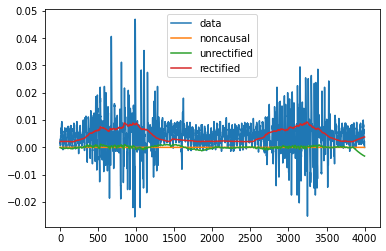

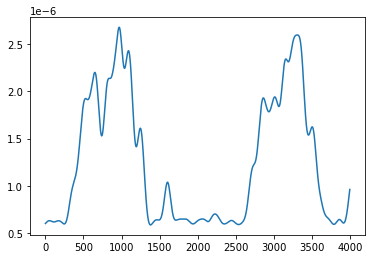

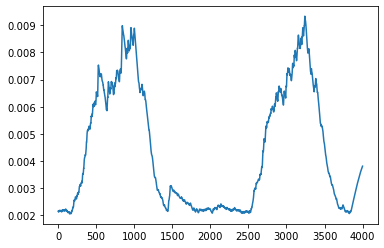

In [19]:
# compare with non-causal blur
dataset = xa.open_dataset("/Users/spencerw/data/2020-04-03-spencer/1585932792_index_spencer.data")
analysis.fill_time_array(dataset)
start_idx = 2000 # first second

data_snippet = dataset.emg.values[:,start_idx:start_idx+5000]*0.0002861
noncausal_snippet = analysis.preprocess(data_snippet)
causal_snippet_unrectified = causal_blur(analysis.demean(data_snippet),half_gaussian(150))
causal_snippet_rectified = causal_blur(analysis.rectify(analysis.demean((data_snippet))),half_gaussian(150))

plt.plot(data_snippet[8,1000:], label="data")
plt.plot(noncausal_snippet[8,1000:],label="noncausal")
plt.plot(causal_snippet_unrectified[8,1000:],label="unrectified")
plt.plot(causal_snippet_rectified[8,1000:],label="rectified")
plt.legend()
plt.figure()
plt.plot(noncausal_snippet[8,1000:])
plt.figure()
plt.plot(causal_snippet_rectified[8,1000:])

In [20]:
np.min(causal_snippet_rectified)
np.max(causal_snippet_rectified)

0.010631177417667071

In [53]:
np.max(dataset.emg.values)
np.min(dataset.emg.values)

-3253

In [21]:
# get data
data_folder = Path('/Users/spencerw/data/2020-04-03-spencer/')
filenames = list(data_folder.rglob('*'))
noise_files = [f for f in filenames if 'noise' in f.name]
data_paths = analysis.data_files(data_folder)

+ /Users/spencerw/data/2020-04-03-spencer
    + 1585932649_noise_spencer.data
    + 1585932727_noise_spencer.data
    + 1585932792_index_spencer.data
    + 1585932979_middle_spencer.data
    + 1585933183_ring_spencer.data
    + 1585933364_pinky_spencer.data
    + 1585933587_index_middle_spencer.data
    + 1585933787_ring_pinky_spencer.data
    + 1585933955_middle_ring_spencer.data
    + 1585934217_index_pinky_spencer.data
    + 1585934390_index_ring_spencer.data
    + 1585934539_middle_pinky_spencer.data
    + 1585934708_index_middle_ring_pinky_spencer.data
    + 1585935459_in_order_spencer.data
    + 1585935877_alternate_index_ring_spencer.data
    + 1585936006_alternate_middle_pinky_spencer.data
    + 1585936129_thumb_spencer.data
    + 1585936295_wrist_down_spencer.data
    + 1585936429_wrist_out_spencer.data


In [22]:
fingers = ['index','middle','ring','pinky']
finger_path_lists = []
for finger in fingers:
    finger_path_lists.append([p for p in data_paths if finger in p.name])
individual_finger_paths = []
for l in finger_path_lists:
    individual_finger_paths.append(l[0])

processed_emg = load_and_preprocess_data(individual_finger_paths[1])

252753


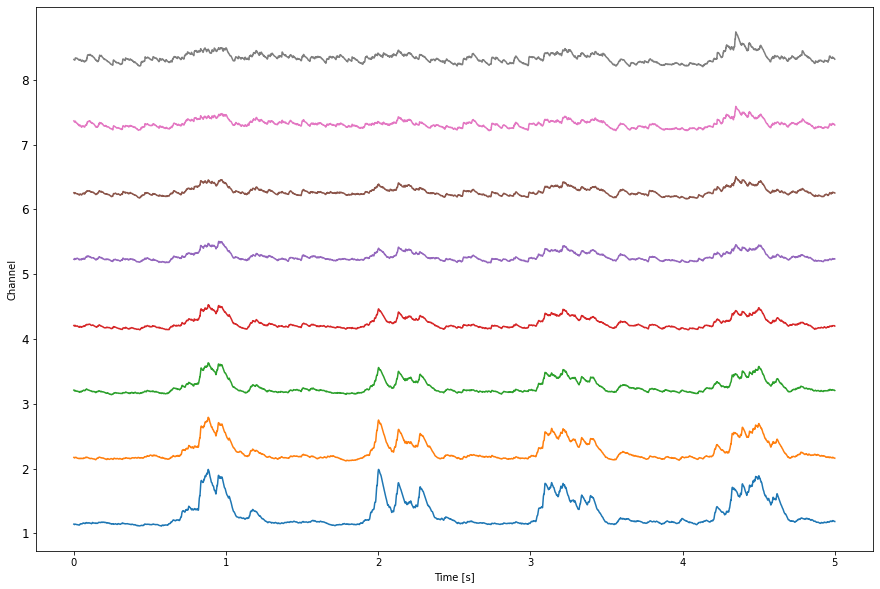

In [23]:
print(processed_emg.shape[1])
# plot data pre and postprocessing
fig = analysis.plot_biolectric(processed_emg[:8,:10000],offset=.01)

In [24]:
# do NMF on each finger separately, then on combinations and compare
for ifp in individual_finger_paths:
    print(ifp)

nmf = NMF(n_components=2, init='random', random_state=42)
nmf_components = []
for path in individual_finger_paths:
    finger_array = load_and_preprocess_data(path)
    # model takes (samples, features)
    nmf.fit(finger_array.T)
    nmf_components.append(nmf.components_)    

/Users/spencerw/data/2020-04-03-spencer/1585932792_index_spencer.data
/Users/spencerw/data/2020-04-03-spencer/1585932979_middle_spencer.data
/Users/spencerw/data/2020-04-03-spencer/1585933183_ring_spencer.data
/Users/spencerw/data/2020-04-03-spencer/1585933364_pinky_spencer.data


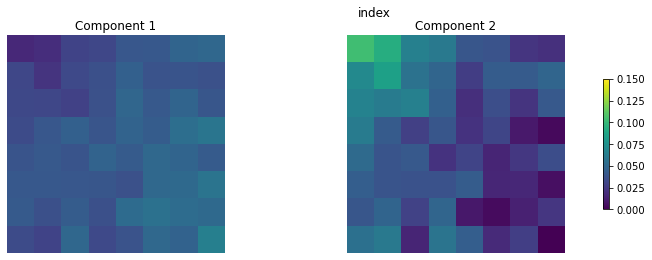

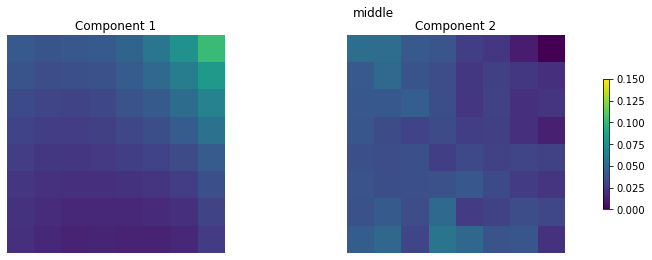

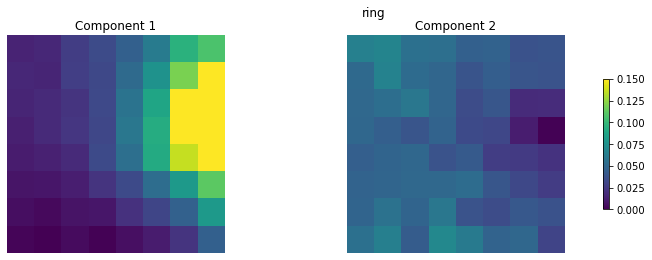

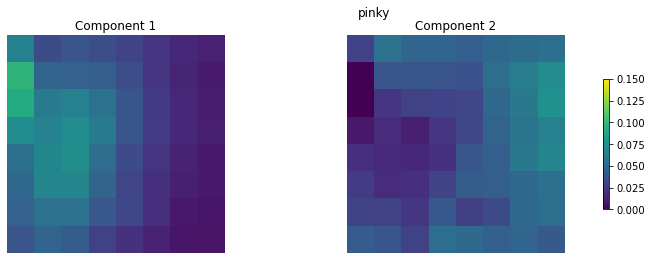

In [25]:
for finger, components in zip(fingers, nmf_components):
#     plot_features_bar(components,title=finger)
    analysis.plot_features_grid(components,vmin=0,vmax=0.15,title=finger)

In [26]:
for path in finger_path_lists:
    for p in path:
        print(p.name)
    print()

1585932792_index_spencer.data
1585933587_index_middle_spencer.data
1585934217_index_pinky_spencer.data
1585934390_index_ring_spencer.data
1585934708_index_middle_ring_pinky_spencer.data
1585935877_alternate_index_ring_spencer.data

1585932979_middle_spencer.data
1585933587_index_middle_spencer.data
1585933955_middle_ring_spencer.data
1585934539_middle_pinky_spencer.data
1585934708_index_middle_ring_pinky_spencer.data
1585936006_alternate_middle_pinky_spencer.data

1585933183_ring_spencer.data
1585933787_ring_pinky_spencer.data
1585933955_middle_ring_spencer.data
1585934390_index_ring_spencer.data
1585934708_index_middle_ring_pinky_spencer.data
1585935877_alternate_index_ring_spencer.data

1585933364_pinky_spencer.data
1585933787_ring_pinky_spencer.data
1585934217_index_pinky_spencer.data
1585934539_middle_pinky_spencer.data
1585934708_index_middle_ring_pinky_spencer.data
1585936006_alternate_middle_pinky_spencer.data



(3, 64)


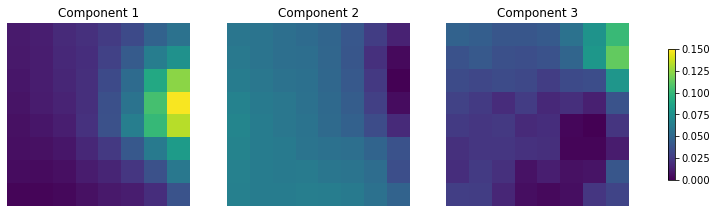

In [27]:
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585935877_alternate_index_ring_spencer.data")
nmf = NMF(n_components=3, init='random', random_state=42)
nmf.fit(d.T)
print(nmf.components_.shape)
_ = analysis.plot_features_grid(nmf.components_,vmin=0,vmax=0.15)

(3, 64)


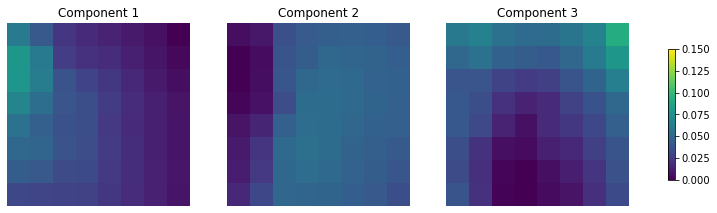

In [28]:
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585936006_alternate_middle_pinky_spencer.data")
nmf = NMF(n_components=3, init='random', random_state=42)
nmf.fit(d.T)
print(nmf.components_.shape)
_ = analysis.plot_features_grid(nmf.components_,vmin=0,vmax=0.15)

(4, 64)


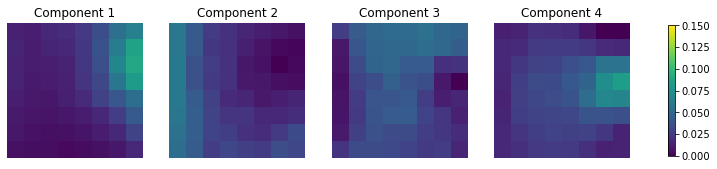

In [29]:
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585934708_index_middle_ring_pinky_spencer.data")
nmf = NMF(n_components=4, init='random', random_state=42)
nmf.fit(d.T)
print(nmf.components_.shape)
_ = analysis.plot_features_grid(nmf.components_,vmin=0,vmax=0.15)

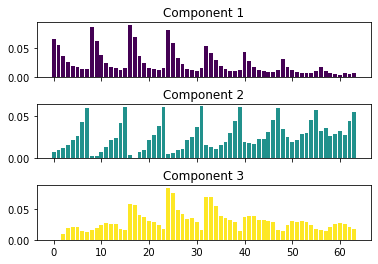

In [30]:
# use 3 components of the four-finger data to make a mapping
mapping = np.empty((3,64))
mapping[0,:] = nmf.components_[0,:]
mapping[1,:] = nmf.components_[1,:]
mapping[2,:] = nmf.components_[3,:]

_ = analysis.plot_features_bar(mapping)

In [31]:
import matplotlib.cm as cm
Dynamics = Linear_Control()
# change control matrix to mapping
Dynamics.B[-3:,:] = mapping
# no y input
# Dynamics.B[-1,:] = 0
# collect input and output data 
timepoints = 100000
cmap = cm.jet
c = np.linspace(0, 10, timepoints)
input_array = np.empty((STATE_DIM, timepoints))
output_array = np.empty((2, timepoints))

In [32]:
# same data (all fingers)
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585934708_index_middle_ring_pinky_spencer.data")
for t in range(timepoints):
    control_input = d[:64,t+10000].reshape(-1,1) # input is EMG data vector
    Dynamics.advance_dynamics(control_input)
    input_array[:,t] = Dynamics.B.dot(control_input)[:,0]
    Dynamics.advance_observation()
    output_array[:,t] = Dynamics.observation[:,0]

Text(0.5, 1.0, 'input x and y forces')

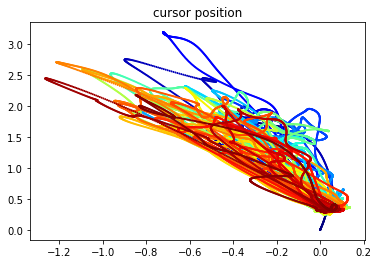

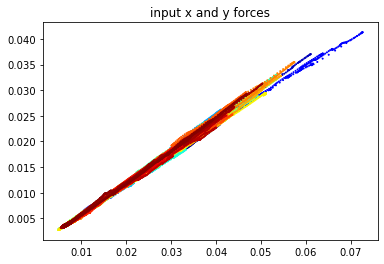

In [33]:
# plot particle trajectory
plt.scatter(output_array[0,:],output_array[1,:],c=c, cmap=cmap, s=1)
plt.title("cursor position")
plt.figure()
plt.scatter(input_array[-3,:]+input_array[-2,:],input_array[-1,:],c=c, cmap=cmap, s=1)
plt.title("input x and y forces")

In [ ]:
| X - UV | **2
U^T = [
    w1
    w2
    w3
    ]
V = [ lt,lt+1, ...  ]


x = Ax + Bu 

px = vxdt 
py 
vx = (-f_left+f_right)dt
vy
f_left
f_right
f_up

B = 
[0 ..
0 ..
0 .
0 ..
c1 --
c2 --
c3 -- 
]


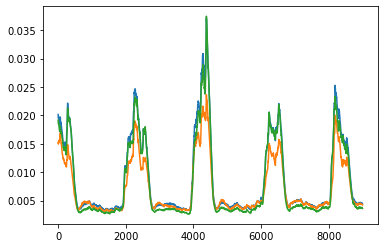

In [34]:
plt.plot(input_array[-1,1000:10000])
plt.plot(input_array[-2,1000:10000])
plt.plot(input_array[-3,1000:10000])

So we see the inputs are super correlated (in time), which makes sense as we're depressed multiple fingers at once. A better dataset might be all four fingers alternating, so that features will describe each finger individually. 

I should figure out how to visualize what the mapping is doing input to output, and think about what constraints exist geometrically to make sure it's possible to reach every point through the given mapping, that it's the directions span the relevant output space. 

If we look at each component of the mapping as each electrode's contribution to the x and y, this might show us the "controllability" of the mapping?

Text(0.5, 1.0, 'input x and y forces')

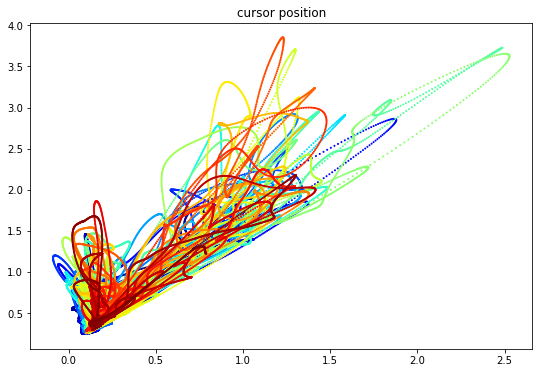

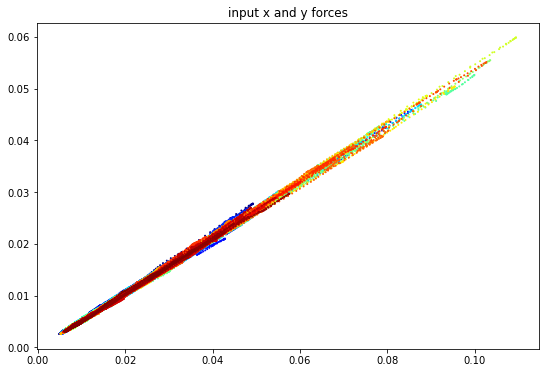

In [25]:
# different data
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585936006_alternate_middle_pinky_spencer.data")
for t in range(timepoints):
    control_input = d[:64,t+10000].reshape(-1,1)
    Dynamics.advance_dynamics(control_input)
    input_array[:,t] = Dynamics.B.dot(control_input)[:,0]
    Dynamics.advance_observation()
    output_array[:,t] = Dynamics.observation[:,0]

# plot particle trajectory
plt.scatter(output_array[0,:],output_array[1,:],c=c, cmap=cmap, s=1)
plt.title("cursor position")
plt.figure()
plt.scatter(input_array[-3,:]+input_array[-2,:],input_array[-1,:],c=c, cmap=cmap, s=1)
plt.title("input x and y forces")

0.04581737653728265 0.000375039762025924


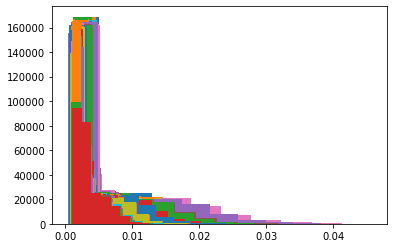

In [39]:
for i in range(d.shape[0]):
    plt.hist(d[i,:])
print(np.max(d),np.min(d))

Pretty heavy tailed... 

52.03088148522998
129
0.04983781107571214


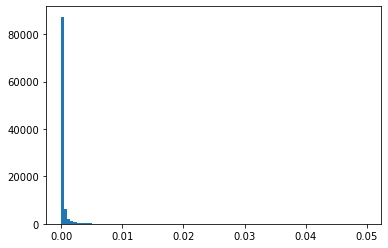

In [51]:
x = np.abs(np.random.standard_cauchy(100000)*.0001)
print(np.max(x))
print(len(x[x>0.05]))
x = x[x<0.05] 
print(np.max(x))
_ = plt.hist(x,bins=100)

On an alternate finger dataset, we see the same kind of correlations

Text(0.5, 1.0, 'input x and y forces')

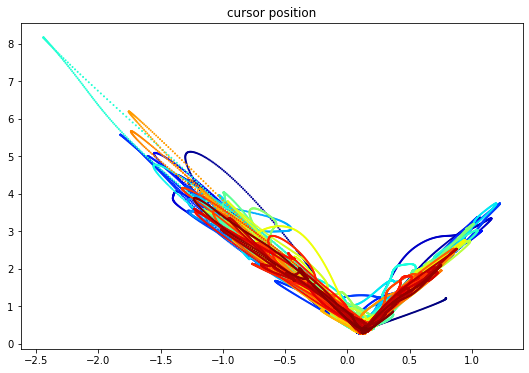

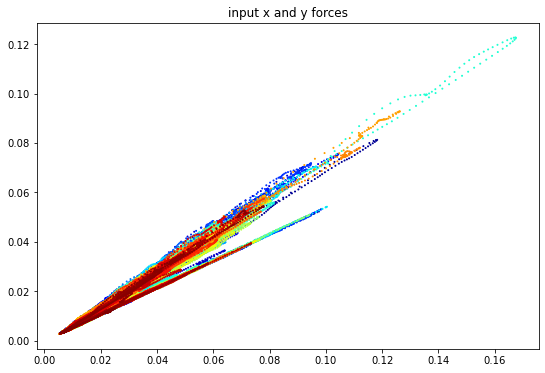

In [26]:
d = load_and_preprocess_data("/Users/spencerw/data/2020-04-03-spencer/1585935877_alternate_index_ring_spencer.data")
for t in range(timepoints):
    control_input = d[:64,t+10000].reshape(-1,1)
    Dynamics.advance_dynamics(control_input)
    input_array[:,t] = Dynamics.B.dot(control_input)[:,0]
    Dynamics.advance_observation()
    output_array[:,t] = Dynamics.observation[:,0]
# plot particle trajectory
plt.scatter(output_array[0,:],output_array[1,:],c=c, cmap=cmap, s=1)
plt.title("cursor position")
plt.figure()
plt.scatter(input_array[-3,:]+input_array[-2,:],input_array[-1,:],c=c, cmap=cmap, s=1)
plt.title("input x and y forces")